# Using Researcher With Tensorflow MNIST

`researcher` makes it easier for you to record and visualize and reproduce the results of your data science experiments. Below we'll demonstrate how this can be done by using researcher to compare the results of different experiments on the tensorflow MNIST dataset (based off the [tensorflow MNIST tutorial](https://www.tensorflow.org/datasets/keras_example)). 

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import researcher as rs

## Prepare the data

First we have to download the MNIST dataset and split it into train and test subsets.

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [4]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Running Experiments

Now we're ready to start training. It's not good enough to just create a model and jump right in though, good data science requires planning. 

First we need to think about what statement we're trying to prove, for instance, perhaps we suspect that [ReLU](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) activation functions perform better on MNIST than [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) functions.

Next we need to determine how we would prove this statement one way or the other. A simple, scientific approach would be to run a series of experiemnts where we train a neural network to recognize MNIST digits, keeping all variables exactly the same except the activation function, and record the final test loss each time. If one activation function has a much lower test loss, then we'll know that that activation function is better for MINST (at least under these specific conditions).

The first step is to define an experiment helper function that will help us re-run exactly the same experiment while varying only the activation function:

In [5]:
def run_experiment(params):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
      tf.keras.layers.Dense(128,activation=params["activation_function"]), # activation function is chosen from params
      tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(0.001),
        metrics=['accuracy'],
    )
    model.fit(
        ds_train,
        epochs=5,
        validation_data=ds_test,
    )
    
    return model.history

This function takes a set of parameters, creates a neural network according to those parameters, trains it on MNIST, and finally returns the results of the training (which are stored in model.history).

Let's try it out.

In [6]:
param_queue = [
    {"activation_function": "relu"},
    {"activation_function": "sigmoid"},
    
]

results = []

for params in param_queue:
    print("\nStarting Next Experiment")
    results.append(run_experiment(params))


Starting Next Experiment
Epoch 1/5
469/469 [==============================] - 1s 2ms/step - loss: 0.3538 - accuracy: 0.9039 - val_loss: 0.1905 - val_accuracy: 0.9454
Epoch 2/5
469/469 [==============================] - 1s 1ms/step - loss: 0.1625 - accuracy: 0.9532 - val_loss: 0.1310 - val_accuracy: 0.9610
Epoch 3/5
469/469 [==============================] - 1s 1ms/step - loss: 0.1148 - accuracy: 0.9672 - val_loss: 0.1125 - val_accuracy: 0.9655
Epoch 4/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0900 - accuracy: 0.9747 - val_loss: 0.1005 - val_accuracy: 0.9695
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0726 - accuracy: 0.9794 - val_loss: 0.0851 - val_accuracy: 0.9741

Starting Next Experiment
Epoch 1/5
469/469 [==============================] - 1s 1ms/step - loss: 0.5956 - accuracy: 0.8571 - val_loss: 0.3065 - val_accuracy: 0.9166
Epoch 2/5
469/469 [==============================] - 1s 1ms/step - loss: 0.2760 - accuracy: 0.9227 - v

## Saving Experiments with `researcher`

Now, just by eyeballing the printed output we can see that the ReLU function seems to perform better than the sigmoid function. 

To get the most out of this experiment though, we need to record the results. If in 6 months a colleague or client asks us which activation to use for an MNIST classifier, we don't want to say "use ReLU, because if I remember correctly, it seemed a bit better than sigmoid". We want to be able to show them the actual data we gathered, so that they know **exactly** how much better, and according to which metrics. We also want to give them the tools to easily re-run the experiment for themselves if they have any doubts.

This is what researcher helps us do: for each experiment we'll save the parameters and the associated experiment outcome to an "experiment" JSON file, then in future we can easily re-analyse or re-create the results.

In [7]:
# create a directory for storing experiments
! mkdir experiments

mkdir: cannot create directory ‘experiments’: File exists


In [8]:
experiment_dir = "experiments/"

for i in range(len(param_queue)):
    params = param_queue[i]
    result_builder = rs.ResultBuilder()
    
    for key, values in results[i].history.items():
        result_builder.add_multiple(fold=0, name=key, values=values)
    
    rs.record_experiment_with_result_builder(params, experiment_dir, result_builder)

In [9]:
! ls experiments

no_title_91601d41e6ba315dd57bd9c2b1db378e.json
no_title_eebb49b9d1487396dd6c0e5271cc3083.json


`researcher`automatically associates each experiment with a hash. We can easily load them again and visualize their outcomes.

In [10]:
experiments = rs.all_experiments(experiment_dir)
experiments

In [11]:
experiments[0].data

{'activation_function': 'relu',
 'hash': 'eebb49b9d1487396dd6c0e5271cc3083',
 'timestamp': '2020-12-09_23:53:05',
 'results': {'fold_results': [{'loss': [0.3538148105144501,
     0.1624753475189209,
     0.11477819830179214,
     0.08997712284326553,
     0.072612464427948],
    'accuracy': [0.9039166569709778,
     0.953166663646698,
     0.9672333598136902,
     0.9747166633605957,
     0.979449987411499],
    'val_loss': [0.19051006436347961,
     0.13104568421840668,
     0.11245104670524597,
     0.100490503013134,
     0.08511549234390259],
    'val_accuracy': [0.9453999996185303,
     0.9610000252723694,
     0.965499997138977,
     0.9695000052452087,
     0.9740999937057495]}],
  'general_results': {}}}

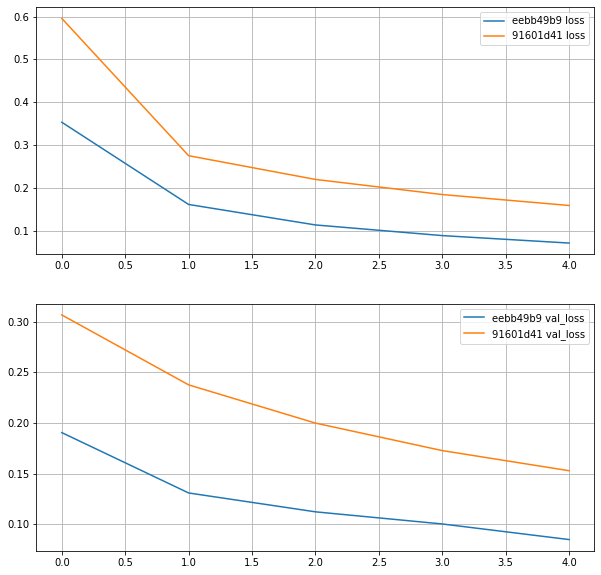

In [13]:
rs.plot_training(experiments, ["loss", "val_loss"], figsize=(10, 10))

## Adding More Experiments

If we want to do more research, we simply run and save more experiments. We can define a function to make this process easier.

In [14]:
def run_and_save(params):
    results = run_experiment(params)
    
    result_builder = rs.ResultBuilder()
    
    for key, values in results.history.items():
        result_builder.add_multiple(0, key, values)
        
    rs.record_experiment_with_result_builder(params, "./experiments/", result_builder)

Now running and recording new experiments becomes very simple. We're also going to give our experiment parameters a `"title"` now, to help us identify that experiment in future.

In [15]:
run_and_save({
    "title": "tanh-activation",
    "activation_function": "tanh"
})

Epoch 1/5
469/469 [==============================] - 1s 1ms/step - loss: 0.3698 - accuracy: 0.8966 - val_loss: 0.2266 - val_accuracy: 0.9349
Epoch 2/5
469/469 [==============================] - 1s 1ms/step - loss: 0.1995 - accuracy: 0.9434 - val_loss: 0.1710 - val_accuracy: 0.9515
Epoch 3/5
469/469 [==============================] - 1s 1ms/step - loss: 0.1450 - accuracy: 0.9591 - val_loss: 0.1298 - val_accuracy: 0.9614
Epoch 4/5
469/469 [==============================] - 1s 1ms/step - loss: 0.1133 - accuracy: 0.9683 - val_loss: 0.1162 - val_accuracy: 0.9646
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0907 - accuracy: 0.9743 - val_loss: 0.0987 - val_accuracy: 0.9715


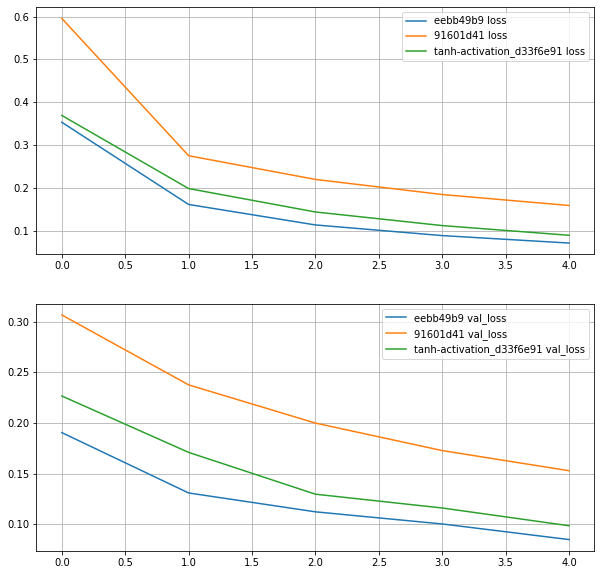

In [16]:
experiments = rs.all_experiments("experiments/")
rs.plot_training(experiments, ["loss", "val_loss"], figsize=(10, 10))

The tanh function seems to perform better than the sigmoid function, but worse than ReLU. Now that we have this data recorded, we can come back and re-confirm or re-assess these conclusions any time we like.

Since the parameters for each experiment are also recorded, we can easily re-run experiments later to confirm that the results haven't changed (for example, we might want to confirm that the results still hold on a newer version of Tensorflow), or on someone else's machine.

In [19]:
experiments[-1].data

{'title': 'tanh-activation',
 'activation_function': 'tanh',
 'hash': 'd33f6e912484ead0cecaf0d4bcf63b33',
 'timestamp': '2020-12-09_23:53:29',
 'results': {'fold_results': [{'loss': [0.36977073550224304,
     0.1994904726743698,
     0.14499413967132568,
     0.11328093707561493,
     0.0907105877995491],
    'accuracy': [0.8966000080108643,
     0.9434000253677368,
     0.9591166377067566,
     0.9682999849319458,
     0.9743333458900452],
    'val_loss': [0.22660541534423828,
     0.1710336059331894,
     0.12982787191867828,
     0.11622746288776398,
     0.09874314814805984],
    'val_accuracy': [0.9348999857902527,
     0.9514999985694885,
     0.9613999724388123,
     0.9646000266075134,
     0.9714999794960022]}],
  'general_results': {}}}